<a href="https://colab.research.google.com/github/Solo7602/MADPA/blob/main/Mosh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-17-c7a19fc7e9e7>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['processed_comment'] = data['Comment'].apply(preprocess_text)
<ipython-input-17-c7a19fc7e9e7>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Age_Group'] = pd.cut(data['Age'], bins=[0, 20, 40, 100], labels=['[0, 20]', '[20, 40]', '[40, 100]'])
<ipython-input-17-c7a19fc7e9e7>:65: SettingWithCopyWar

Training until validation scores don't improve for 137 rounds
Early stopping, best iteration is:
[231]	valid_0's multi_logloss: 0.97742
              precision    recall  f1-score   support

           0       0.44      0.60      0.51      2397
           1       0.64      0.48      0.55      4226
           2       0.39      0.46      0.42      1377

    accuracy                           0.51      8000
   macro avg       0.49      0.51      0.49      8000
weighted avg       0.54      0.51      0.51      8000

Accuracy: 0.510875


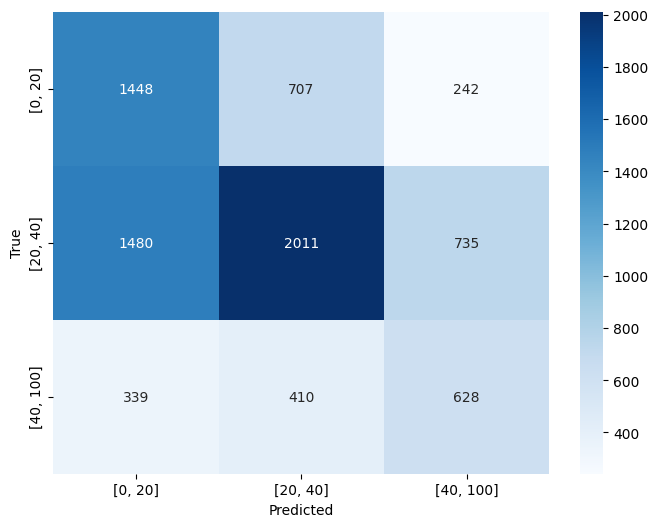

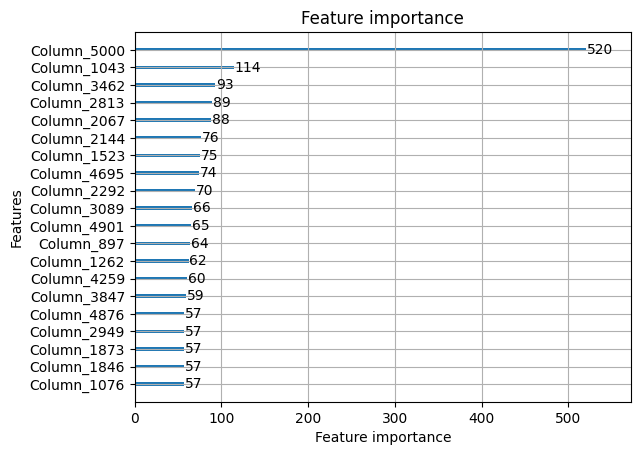

In [17]:
import pandas as pd
import re
from pymorphy3 import MorphAnalyzer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from scipy.sparse import hstack
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

# Загрузка данных
data_long = pd.read_csv('10k_dataset_processed_final.csv')
data = data_long.head(40000)

# Инициализация морфологического анализатора
morph = MorphAnalyzer()

# Получение стоп-слов для русского языка
stop_words = set(stopwords.words('russian'))

sentences = [preprocess_text(comment) for comment in data['Comment'] if isinstance(comment, str)]

model = Word2Vec(
    sentences=sentences,
    vector_size=300,      # Размерность эмбеддингов
    window=5,            # Размер окна контекста
    min_count=3,         # Минимальная частота слова
    workers=4,           # Количество потоков
    epochs=10,           # Количество эпох
    sg=1,                # 1 — skip-gram, 0 — CBOW
)

# Сохранение модели
model.save("word2vec_ru.model")

# def preprocess_text(text):
#     # Удаление эмодзи и специальных символов
#     text = re.sub(r'[^\w\s]', '', text)
#     # Приведение к нижнему регистру
#     text = text.lower()
#     # Токенизация
#     words = text.split()
#     # Лемматизация и удаление стоп-слов
#     words = [morph.parse(word)[0].normal_form for word in words if word not in stop_words]
#     return ' '.join(words)

def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    lemmas = [morph.parse(token)[0].normal_form for token in tokens]
    return lemmas

# Применение предобработки к тексту комментариев
data['processed_comment'] = data['Comment'].apply(preprocess_text)

# Инициализация TF-IDF векторизатора
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Преобразование текста в TF-IDF матрицу
text_features = tfidf.fit_transform(data['processed_comment'])

# Дискретизация Age
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 20, 40, 100], labels=['[0, 20]', '[20, 40]', '[40, 100]'])

interval = {'interval': ['[0, 20]', '[20, 40]', '[40, 100]']}
interval_to_category = {
    '[0, 20]': 0,
    '[20, 40]': 1,
    '[40, 100]': 2
}

data['Age_Category'] = data['Age_Group'].map(interval_to_category).astype(int)

# Ручной синтез
data['Comment_Length'] = data['Comment'].apply(len)


# Масштабирование
scaler = StandardScaler()
numeric_features = data[['Comment_Length']].values
scaled_numeric = scaler.fit_transform(numeric_features)

X = hstack([text_features, scaled_numeric])
y = data['Age_Category']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, data['Age_Category'], test_size=0.2, random_state=42
)

# Балансировка классов
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

# Создание Dataset для LightGBM
train_data = lgb.Dataset(X_resampled, label=y_resampled)
test_data = lgb.Dataset(X_test, label=y_test)

# Параметры модели
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': [0.01, 0.07, 0.1],
    'num_leaves': [31, 63, 127],
    'max_depth': -1,
    'min_child_samples': [10, 20, 30],
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Callback для ранней остановки
early_stopping = lgb.early_stopping(stopping_rounds=137, verbose=True)

# Обучение модели с правильным использованием early stopping
model = lgb.train(params,
                 train_data,
                 valid_sets=[test_data],
                 num_boost_round=1000,
                 callbacks=[early_stopping])

# Предсказание
y_pred = model.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)

# Оценка модели
print(classification_report(y_test, y_pred_class))
print(f"Accuracy: {accuracy_score(y_test, y_pred_class)}")

# Визуализация
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=interval_to_category.keys(),
            yticklabels=interval_to_category.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

lgb.plot_importance(model, max_num_features=20)
plt.show()

In [18]:
pip install gensim python-Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol